In [60]:
import torch

from matplotlib import pyplot as plt
from pathlib import Path

from lafomo.plot import plot_phase, Colours, tight_kwargs
from lafomo.utilities.torch import inv_softplus, softplus
from lafomo.datasets import DeterministicLotkaVolterra
from experiments.lotka import build_lotka, plot_lotka
from lafomo.configuration import VariationalConfiguration
from lafomo.trainers import VariationalTrainer
import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


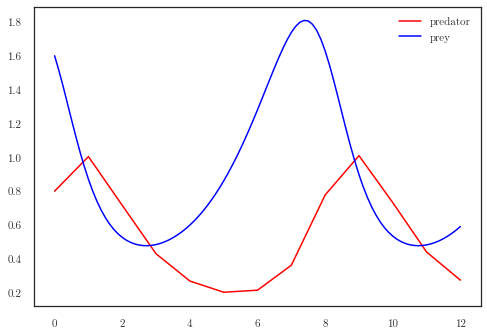

In [2]:
datasets = [DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12,
    fixed_initial=i
) for i in [j*0.8 for j in range(1, 2)]]
dataset = datasets[0]
x_min, x_max = min(dataset.times), max(dataset.times)
plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]

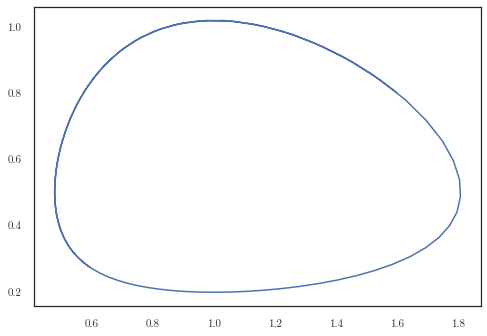

In [3]:
plt.figure()
for dataset in datasets:
    real_prey, real_pred = dataset.prey, dataset.predator
    plt.plot(real_prey, real_pred)
dataset = datasets[0]

In [4]:
params = dict(
    natural=False,
    kernel='periodic'
)
lfm, trainer, plotter = build_lotka(
    dataset, params
    # reload='../../../experiments/lotka/lotka/0savedmodel'
    # reload='./twentyinducing'
)

Num training points:  13
PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


C:\Users\Jacob\Documents\proj\lafomo\lafomo\models\variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


In [34]:
params2 = dict(
    natural=False,
    kernel='rbf'
)
lfm2, trainer2, plotter2 = build_lotka(
    dataset, params2
    # reload='../../../experiments/lotka/lotka/0savedmodel'
    # reload='./twentyinducing'
)

Num training points:  13


C:\Users\Jacob\Documents\proj\lafomo\lafomo\models\variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


In [41]:
trainer2.train(100, report_interval=10, step_size=5e-1);

Epoch 301/400 - Loss: -0.00 (-0.56 0.56) kernel: [[[1.3258264]]]
Epoch 311/400 - Loss: -0.02 (-0.59 0.57) kernel: [[[1.3188294]]]
Epoch 321/400 - Loss: -0.02 (-0.65 0.63) kernel: [[[1.3109844]]]
Epoch 331/400 - Loss: -0.07 (-0.71 0.64) kernel: [[[1.3128178]]]
Epoch 341/400 - Loss: -0.02 (-0.71 0.69) kernel: [[[1.2996165]]]
Epoch 351/400 - Loss: 0.02 (-0.70 0.72) kernel: [[[1.281575]]]
Epoch 361/400 - Loss: 0.09 (-0.62 0.71) kernel: [[[1.2568114]]]
Epoch 371/400 - Loss: -0.03 (-0.72 0.69) kernel: [[[1.2509589]]]
Epoch 381/400 - Loss: -0.05 (-0.72 0.67) kernel: [[[1.2469707]]]
Epoch 391/400 - Loss: -0.04 (-0.71 0.67) kernel: [[[1.2452887]]]


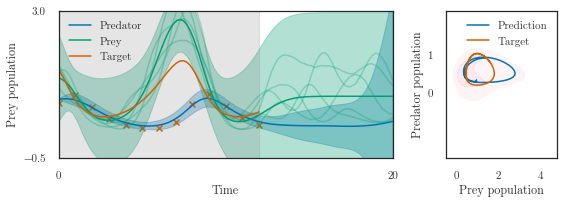

In [42]:
plot_lotka(dataset, lfm2, trainer2, plotter2, Path('./'), params2)

In [32]:
trainer.train(100, report_interval=10, step_size=5e-1);

Epoch 501/600 - Loss: 1.49 (-0.56 2.05) kernel: [[[3.6569614]]]
Epoch 511/600 - Loss: 0.08 (-1.13 1.21) kernel: [[[3.617697]]]
Epoch 521/600 - Loss: -0.20 (-1.21 1.01) kernel: [[[3.584854]]]
Epoch 531/600 - Loss: -0.53 (-1.47 0.95) kernel: [[[3.5679996]]]
Epoch 541/600 - Loss: -0.58 (-1.50 0.92) kernel: [[[3.560388]]]
Epoch 551/600 - Loss: -0.72 (-1.64 0.92) kernel: [[[3.558345]]]
Epoch 561/600 - Loss: -0.77 (-1.69 0.91) kernel: [[[3.5541663]]]
Epoch 571/600 - Loss: -0.77 (-1.69 0.92) kernel: [[[3.549302]]]
Epoch 581/600 - Loss: -0.80 (-1.73 0.93) kernel: [[[3.5459208]]]
Epoch 591/600 - Loss: -0.79 (-1.71 0.92) kernel: [[[3.5372953]]]


tensor([[0.7076]], dtype=torch.float64, grad_fn=<LogBackward>)


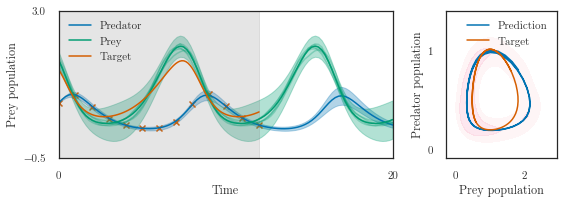

In [33]:
print(lfm.growth_rate)
# plt.style.use('seaborn-white')
plot_lotka(dataset, lfm, trainer, plotter, Path('./'), params)
plt.savefig('1.2periodic-combined.pdf')
# lfm.save('./twentyinducing')

In [30]:
print(lfm.decay_rate)
with torch.no_grad():
    # lfm.raw_growth+= 0.1
    lfm.raw_decay += 0.1
print(lfm.growth_rate)
print(lfm.gp_model.covar_module.base_kernel.period_length)
print(lfm.gp_model.mean_module.constant)

tensor([[0.6838]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[0.6937]], dtype=torch.float64, grad_fn=<LogBackward>)
tensor([[[8.0405]]], grad_fn=<SoftplusBackward>)
Parameter containing:
tensor([[0.5271]], requires_grad=True)


torch.Size([97])
torch.Size([97])


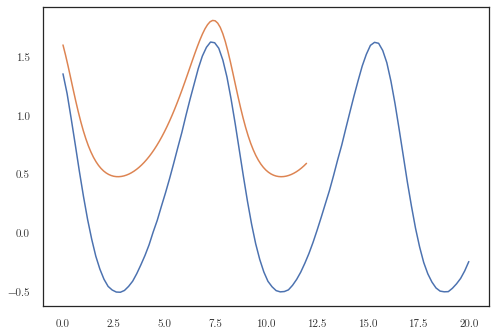

In [21]:
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.mlls import VariationalELBO
lfm.gp_model.train()
gp_model = lfm.gp_model
print(dataset.prey.shape)
print(dataset.times.shape)

likelihood = MultitaskGaussianLikelihood(num_tasks=1)

mll = VariationalELBO(likelihood, gp_model, num_data=dataset.prey.shape[0])
optimizer = torch.optim.Adam([
    {'params': gp_model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

#train gp_model
for i in range(150):
    optimizer.zero_grad()
    output = gp_model(dataset.times)
    loss = -mll(output, inv_softplus(dataset.prey.unsqueeze(-1)))
    loss.backward()
    optimizer.step()

t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)

q_f = gp_model(t_predict)
samples = q_f.sample(torch.Size([10]))
plt.plot(t_predict, samples.mean(0))
plt.plot(dataset.times, dataset.prey)

tensor([[0.4971]], dtype=torch.float64, grad_fn=<LogBackward>) tensor([[0.5817]], dtype=torch.float64, grad_fn=<AddBackward0>)


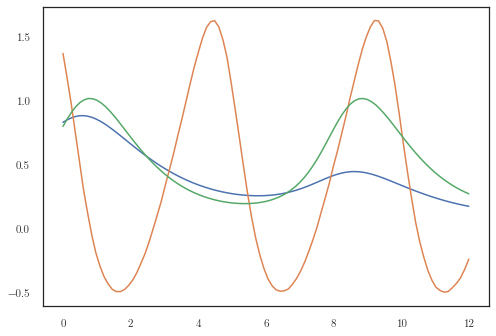

In [13]:
# with torch.no_grad():
#     lfm.raw_growth *= 0
#     lfm.raw_growth += inv_softplus(torch.tensor(1))
#     lfm.raw_decay *= 0
#     lfm.raw_decay += inv_softplus(torch.tensor(1.1))
#     lfm.raw_initial *= 0
#     lfm.raw_initial += inv_softplus(torch.tensor(0.8))
print(lfm.growth_rate, lfm.decay_rate)
gp_model.eval()
lfm.eval()

t_interval = (0, 12)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
output = lfm(t_predict, step_size=1e-1)


plt.plot(t_predict, output.mean.detach().squeeze())
plt.plot(t_predict, samples.mean(0))
plt.plot(dataset.times, dataset.predator)

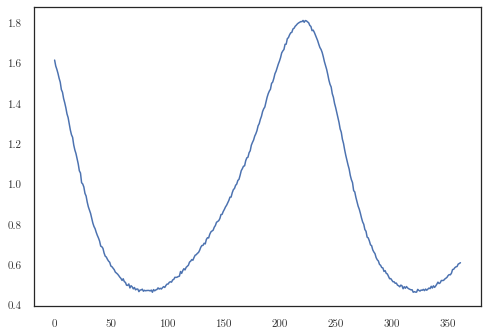

In [8]:
t = t_predict
step_size = 1e-1
t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)

q_f = gp_model(t_f)

f = q_f.rsample(torch.Size([5])).permute(0, 2, 1).mean(0)  # (S, I, T)
plt.plot(f[0].detach())

In [56]:
import importlib
from lafomo.plot import misc
importlib.reload(misc)

<module 'lafomo.plot.misc' from 'C:\\Users\\Jacob\\Documents\\proj\\lafomo\\lafomo\\plot\\misc.py'>

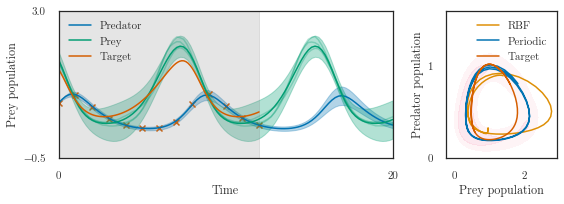

In [65]:
# Copied from plot_lotka
lfm.eval()
t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)
ylim = (-0.5, 3)
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_xlim(*t_interval)
# axes[0].legend()

plotter.plot_gp(q_f, t_predict, num_samples=3,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Prey population')
axes[0].plot(dataset.times, dataset.prey, c=Colours.scatter_color, label='Target')
axes[0].set_xticks([t_predict[0], t_predict[-1]])
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2, integer=True))
axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()
real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

prey2 = lfm2.likelihood(lfm2.gp_model(t_predict))
predator2 = lfm2(t_predict)
prey_mean2 = prey2.mean.detach().squeeze()
predator_mean2 = predator2.mean.detach().squeeze()
axes[1].plot(softplus(prey_mean2), predator_mean2, label='RBF', color=Colours.error_color)

misc.plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred,
           ax=axes[1], pred_label='Periodic')
axes[1].set_ylim(0.2, 1.6)
axes[1].set_xlabel('Prey population')
axes[1].set_ylabel('Predator population')
axes[1].set_yticks([0, 1])
plt.tight_layout()
plt.savefig('lotka-combined.pdf', **tight_kwargs)

In [ ]:
v_targ = dataset.delta * real_prey - dataset.gamma * torch.log(real_prey) + dataset.beta * real_pred - dataset.alpha * torch.log(real_pred)
v_pred = dataset.delta * prey_mean - dataset.gamma * torch.log(prey_mean) + dataset.beta * predator_mean - dataset.alpha * torch.log(predator_mean)

plt.figure()
plt.plot(torch.linspace(0, 12, v_targ.shape[0]), v_targ, label='Target')
plt.plot(t_predict, v_pred, label='Prediction')

In [9]:
with torch.no_grad():
    lfm.raw_decay += 0.3
    lfm.raw_growth += 0.3
print(lfm.decay_rate, lfm.growth_rate)
print(dict(lfm.gp_model.mean_module.named_parameters()))

tensor([[0.8209]], dtype=torch.float64) tensor([[0.7084]], dtype=torch.float64)
{'constant': Parameter containing:
tensor([[0.4244]], dtype=torch.float64)}


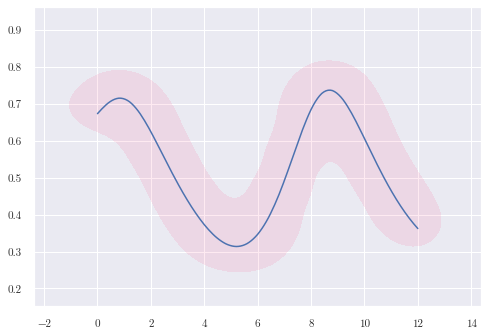

In [39]:
kdeplot(x=t_predict.repeat(50), y=y_samples.flatten(), fill=True, color='pink', alpha=0.1, levels=2, thresh=.1,)
plt.plot(t_predict, predator.mean.detach())